# Recap LAB.5 Solutions

In this lab we do a comparison of the various dimensionality reduction methods. First we import the useful modules and download the dataset.

In [1]:
import numpy as np # linear algebra
import pandas as pd # manipulate data    
import gzip # unpacking zip
import struct # unpacking zip
import sklearn # for comparisons
import matplotlib.pyplot as plt # plotting
import torch # for NNs
from sklearn.model_selection import train_test_split # for preprocessing

## Exercise 1 

Downloading the dataset

In [2]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
        
Xtrain = read_idx('../Datasets/fashion_mnist//train-images-idx3-ubyte.gz')
ytrain=read_idx('../Datasets/fashion_mnist/train-labels-idx1-ubyte.gz')

Xtest = read_idx('../Datasets/fashion_mnist//t10k-images-idx3-ubyte.gz')
ytest =read_idx('../Datasets/fashion_mnist/t10k-labels-idx1-ubyte.gz')

<ipython-input-2-d9e5d408afbd>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


Let's do a train test split, and use a subsection of the all dataset. We normalize to have all images between [0, 1]

In [3]:
Xtrain, _, ytrain, _ = train_test_split(Xtrain, ytrain, train_size = 5000, random_state=0)
_, Xtest, _, ytest = train_test_split(Xtest, ytest, test_size = 100, random_state=0)

# printing shapes
print(f'Train shape: {Xtrain.shape}')
print(f'Test shape: {Xtrain.shape}')

# normalizing
Xtrain = Xtrain/255
Xtest = Xtest/255 

# reshaping
Xtrain = Xtrain.reshape((Xtrain.shape[0],-1))
Xtest = Xtest.reshape((Xtest.shape[0],-1))

Train shape: (5000, 28, 28)
Test shape: (5000, 28, 28)


We start with the exercise, let's import the useful modules

In [4]:
from reduction import PCA, KernelPCA            # our implementation
from sklearn.manifold import Isomap, TSNE       # implementation sklearn
import torch

Let's make a simple function for visualization

In [5]:
def plot_latent(latent, classes, title):
    cmap = plt.get_cmap('jet', 10)
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(1, 2, 1)
    p = ax.scatter(latent[:, 0], latent[:, 1], c=classes, cmap=cmap)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(latent[:, 0], latent[:, 1], latent[:, 2], c=classes, cmap=cmap)
    cb = plt.colorbar(p, location='left')
    cb.ax.set_title('Class', fontsize=11)
    plt.gca().set_title(title, fontsize=20)
    plt.show()


We start by visualizig **PCA**

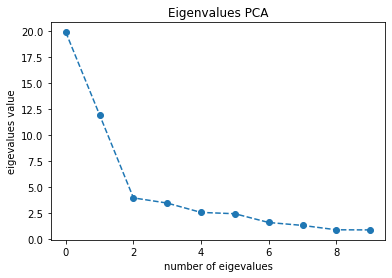

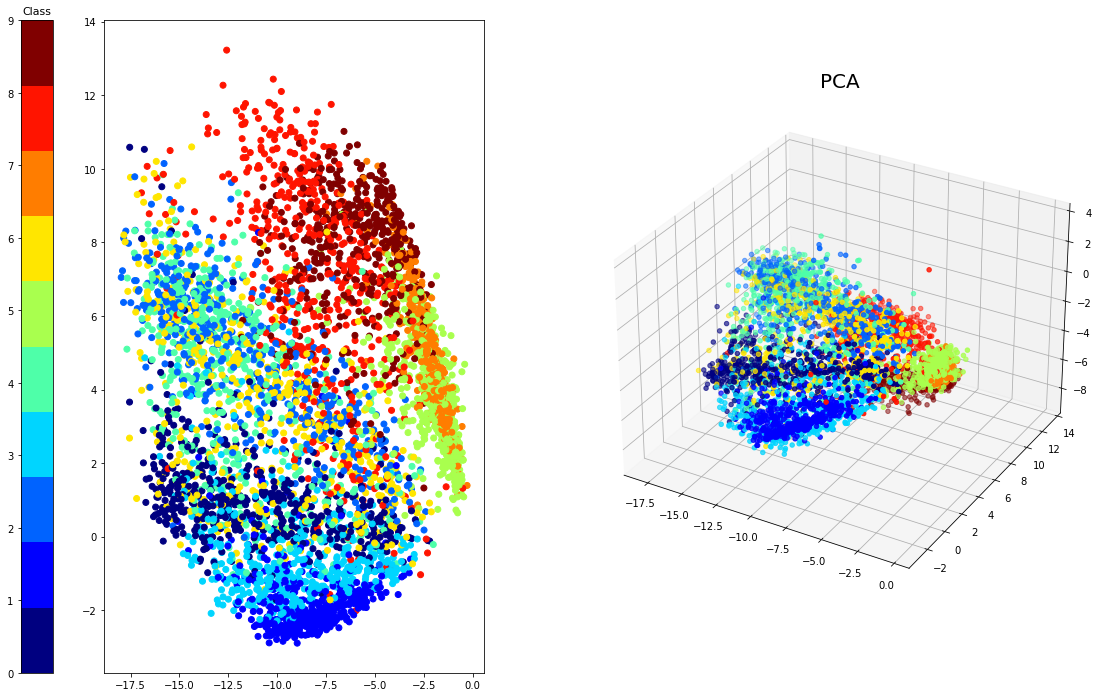

In [8]:
pca = PCA()
pca.fit(Xtrain)
X_pca = pca.transform(Xtrain)

# plotting eigenvalues (first 10 components)
plt.title('Eigenvalues PCA')
plt.plot(range(10), pca.eigenvalues[:10], '--o')
plt.xlabel('number of eigevalues')
plt.ylabel('eigevalues value')
plt.show()

# plotting latent spaces
plot_latent(X_pca, ytrain, 'PCA')


Let's visualize kernel PCA, we start with gaussian kernel

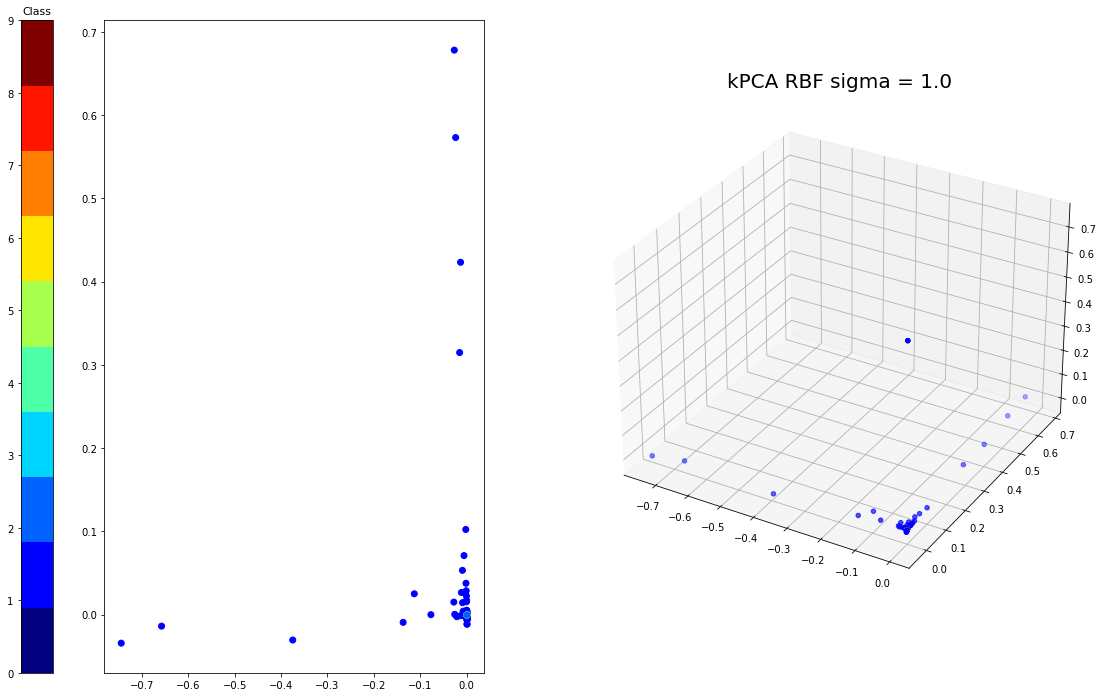

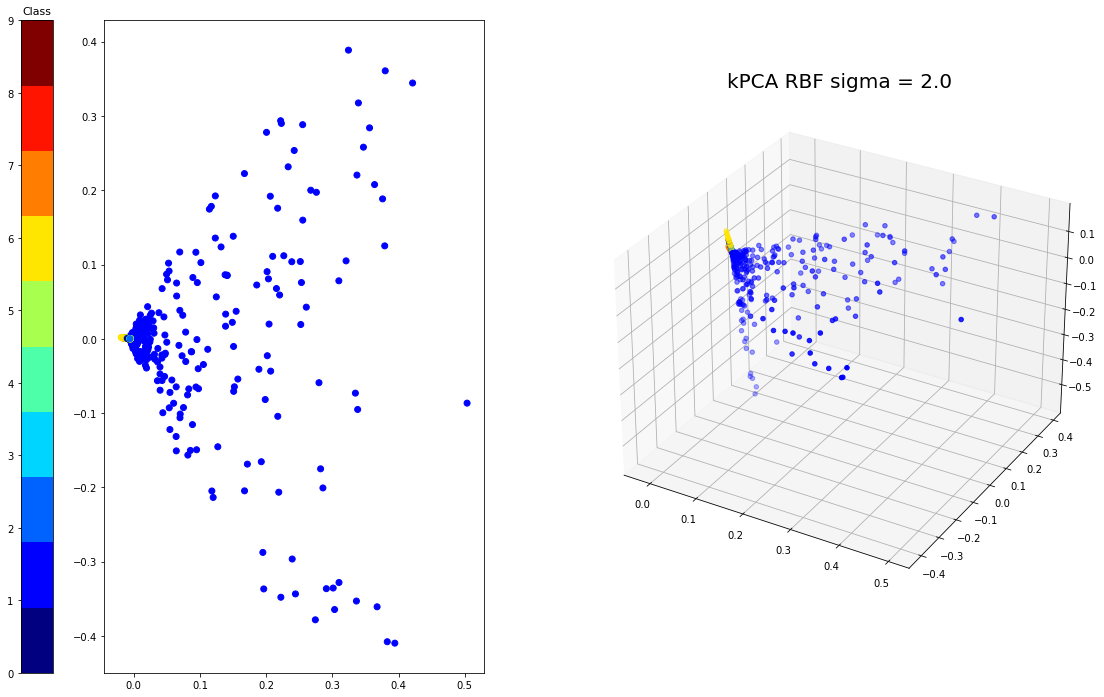

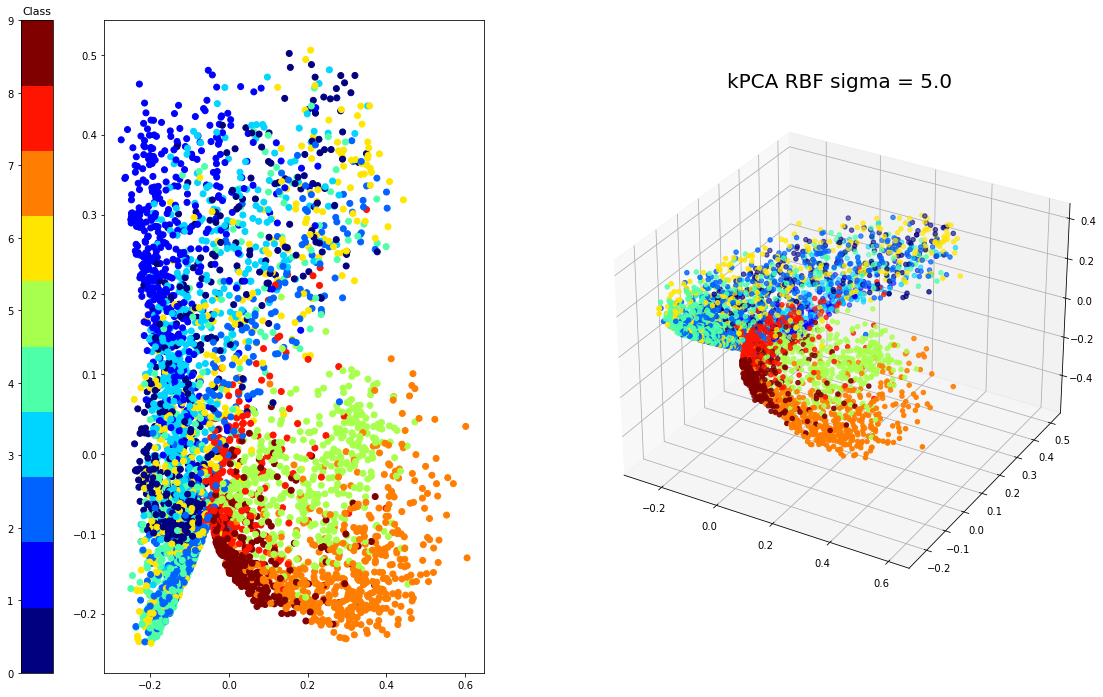

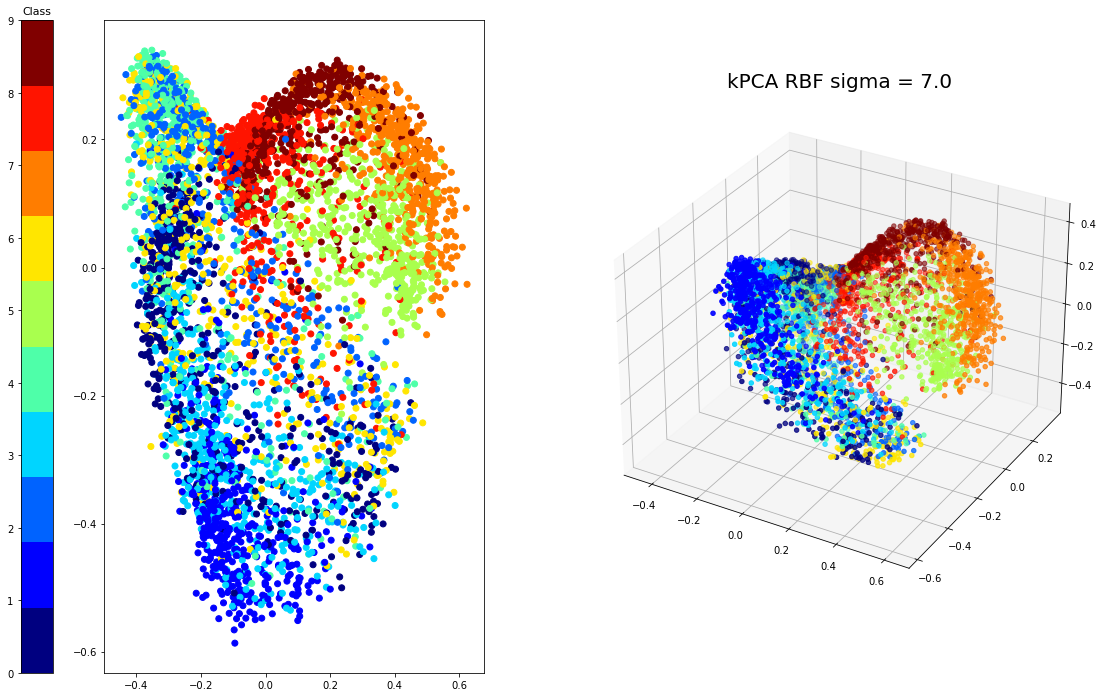

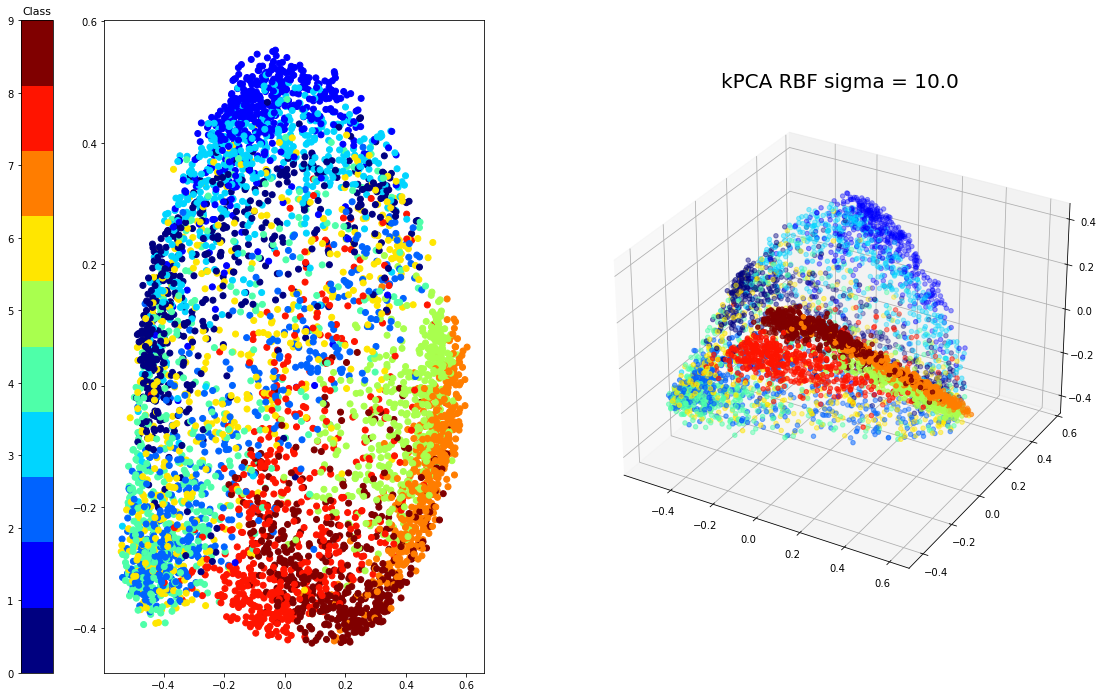

In [9]:
for sigma in (1., 2., 5., 7., 10.):
    kpca = KernelPCA('gaussian', gamma=(sigma)**(-2))
    X_kpca = kpca.fit_transform(Xtrain, numb_components=3)
    plot_latent(X_kpca, ytrain, f'kPCA RBF sigma = {sigma}')

We now try for polynomial kernel

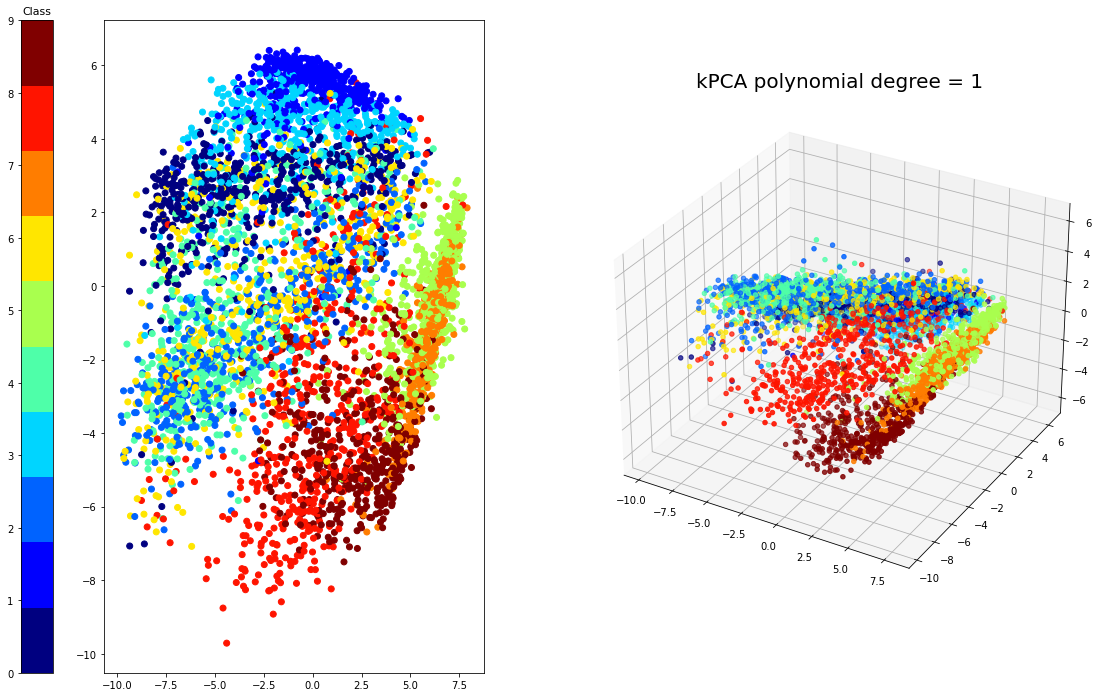

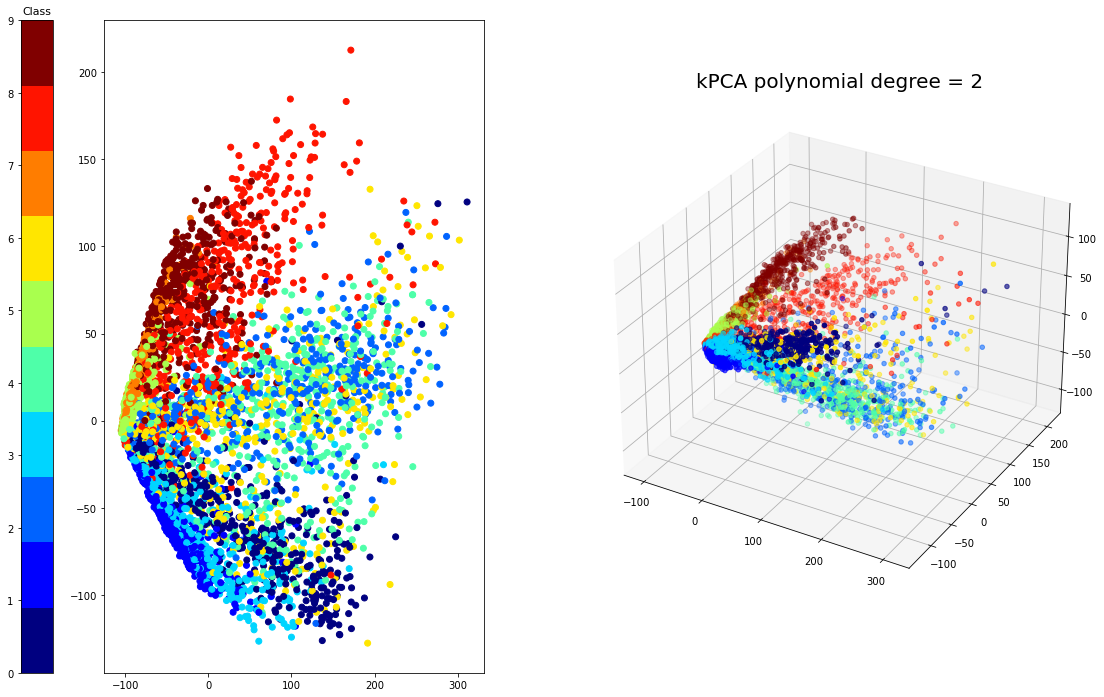

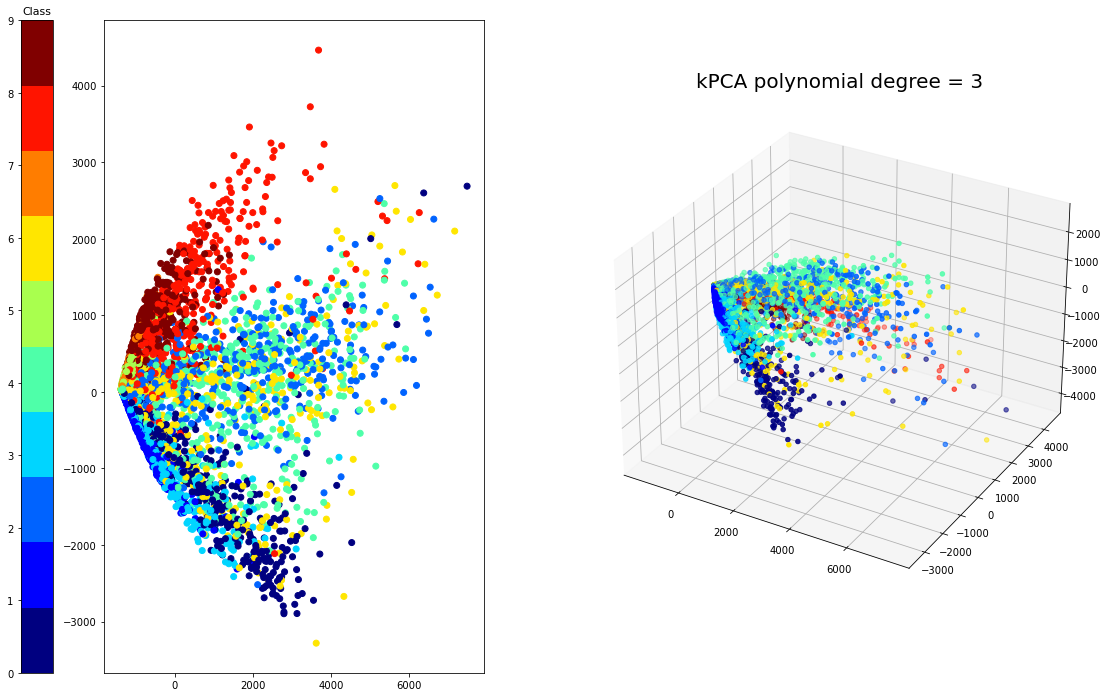

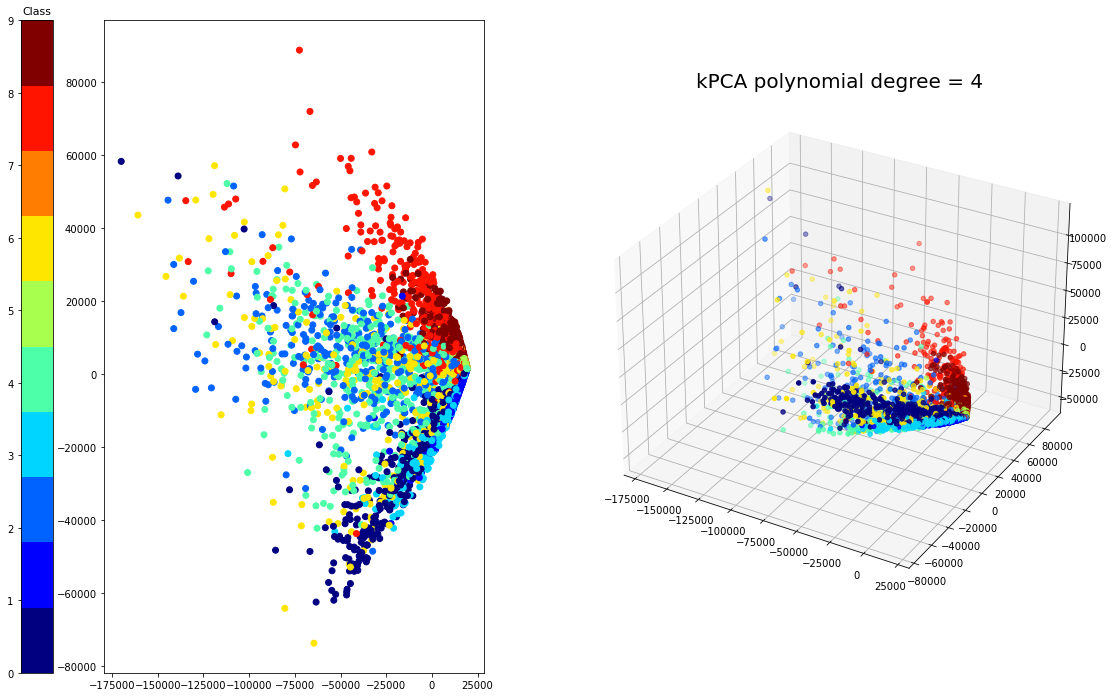

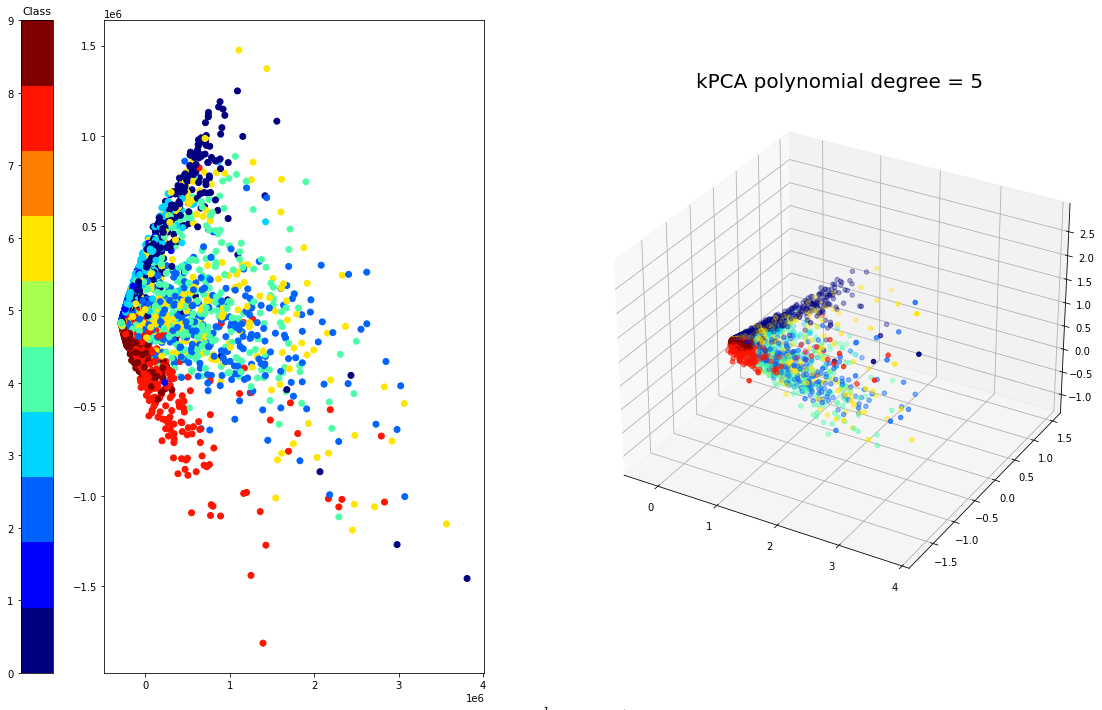

In [18]:
for degree in range(1, 6):
    kpca = KernelPCA('poly', gamma=degree)
    X_kpca = kpca.fit_transform(Xtrain, numb_components=3)
    plot_latent(X_kpca, ytrain, f'kPCA polynomial degree = {degree}')

We now use the sklearn **ISOMAP** and **TSNE** implementation.

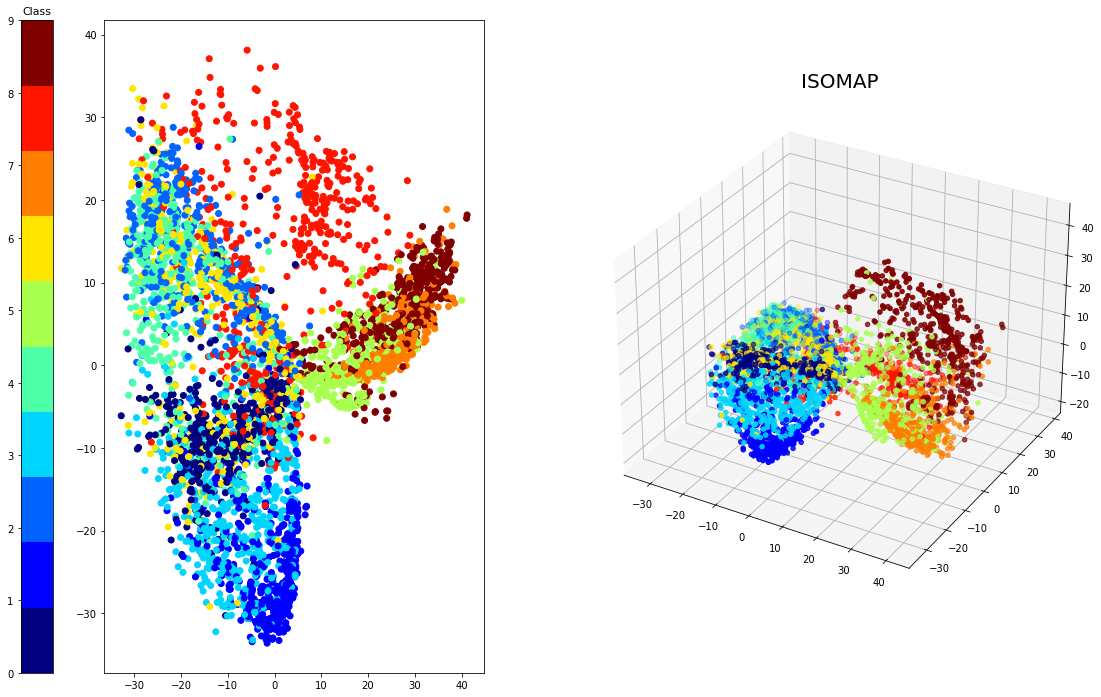

In [19]:
isomap = Isomap(n_components=3, path_method='FW')
X_isomap = isomap.fit_transform(Xtrain)
plot_latent(X_isomap, ytrain, 'ISOMAP')

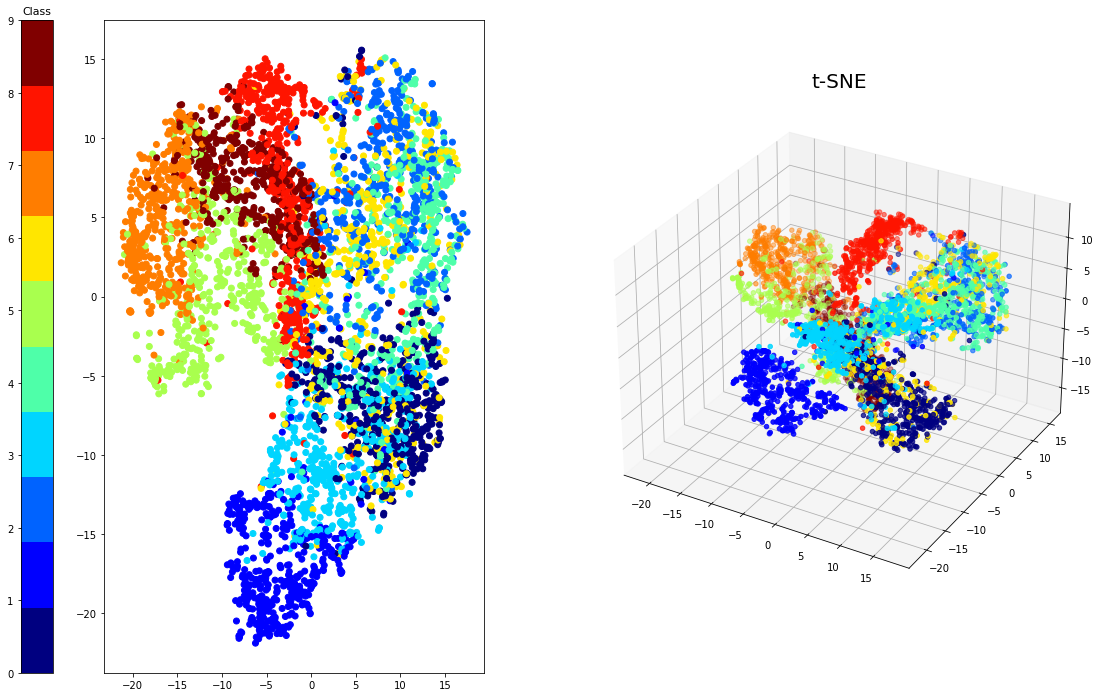

In [10]:
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(Xtrain)
plot_latent(X_tsne, ytrain, 't-SNE')

Finally we use an autoencoder for reducing the dimensionality

In [11]:
class Autoencoder(torch.nn.Module):
    def __init__(self,  dim):
        super().__init__()

        self.dim = dim
        self.encoder = torch.nn.Sequential(torch.nn.Linear(in_features=28*28, out_features=256),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(in_features=256, out_features=32),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(32,self.dim)
                                           )
        self.decoder = torch.nn.Sequential(torch.nn.Linear(in_features=self.dim, out_features=32),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(in_features=32, out_features=256),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(in_features=256, out_features=28*28)
                                           )

        self.ae = torch.nn.Sequential(self.encoder, self.decoder)
                                           
    def forward(self, x):
        return self.ae(x)

    def fit_transform(self, x, train_loader, val_loader, 
                      loss_func=torch.nn.MSELoss, optimizer=torch.optim.Adam,
                      learning_rate = 0.01,
                      num_epochs=50):
        
        model = self.ae
        optim = optimizer(model.parameters(), lr=learning_rate)
        loss_func = loss_func()
        l_train =[]
        l_val = []

        for epoch in range(num_epochs+1): 
            model.train()
            loss_tr=[]

            for step, (images_raw, images_out) in enumerate(train_loader):
                y = model(images_raw)
                loss = loss_func(images_out, y)
                loss_tr.append(loss.detach().item())
                optim.zero_grad()
                loss.backward()
                optim.step()

            model.eval()
            loss_ts = []
            for step, (images_raw, images_out) in enumerate(val_loader):
                y = model(images_raw)
                loss = loss_func(images_out, y)       
                loss_ts.append(loss.detach().cpu().numpy())
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, training_loss: {np.mean(loss_tr)}, validation_loss {np.mean(loss_ts)}")

            l_train.append(np.mean(loss_tr))
            l_val.append(np.mean(loss_ts))


# make training loader
train_set = torch.utils.data.TensorDataset(torch.tensor(Xtrain, dtype=torch.float), torch.tensor(Xtrain, dtype=torch.float))
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set) * 0.8), round(len(train_set) * 0.2)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

# build the autoencoder
ae = Autoencoder(3)
ae.fit_transform(Xtrain, train_loader, val_loader, num_epochs=100)


Epoch 0, training_loss: 0.0873180131893605, validation_loss 0.05365625023841858
Epoch 10, training_loss: 0.030912395217455924, validation_loss 0.031699925661087036
Epoch 20, training_loss: 0.024903689802158624, validation_loss 0.026918839663267136
Epoch 30, training_loss: 0.02372696006204933, validation_loss 0.02536376193165779
Epoch 40, training_loss: 0.023347890586592257, validation_loss 0.02503436803817749
Epoch 50, training_loss: 0.022876072500366718, validation_loss 0.025271596387028694
Epoch 60, training_loss: 0.022409746306948364, validation_loss 0.024873238056898117
Epoch 70, training_loss: 0.022481239575427026, validation_loss 0.02476155012845993
Epoch 80, training_loss: 0.02151510666590184, validation_loss 0.024691741913557053
Epoch 90, training_loss: 0.021411474619526416, validation_loss 0.0244697704911232
Epoch 100, training_loss: 0.021325053996406496, validation_loss 0.024830792099237442


Let's visualize the representation

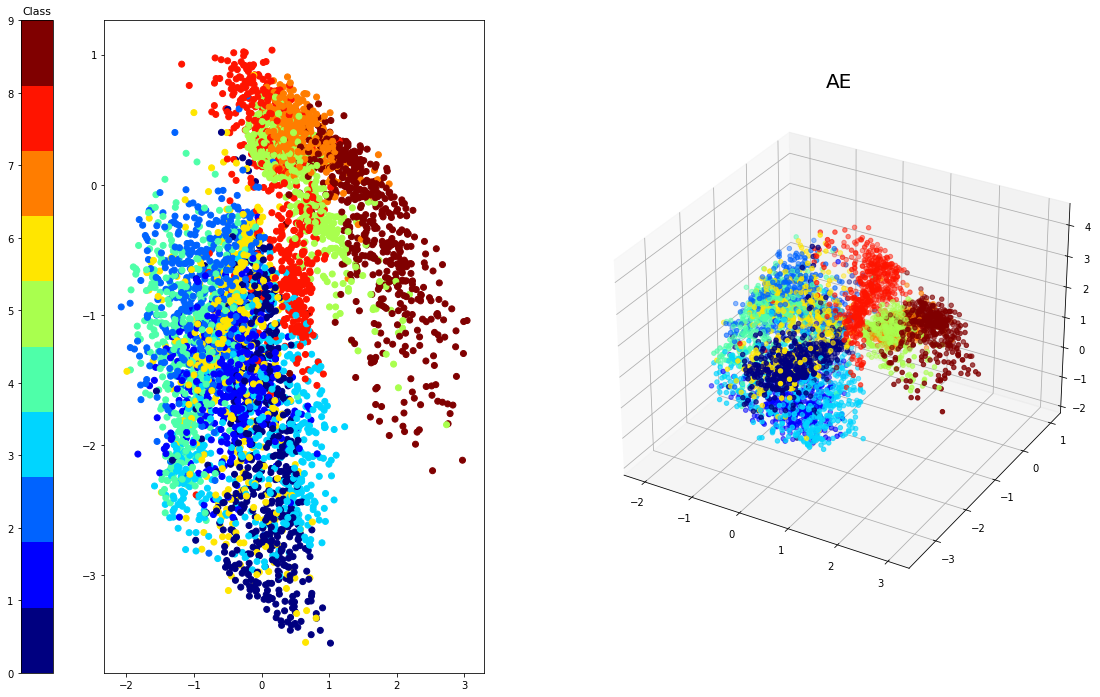

In [12]:
plot_latent(ae.encoder(train_set.dataset.tensors[0]).detach(), ytrain, 'AE')

We can also plot the reconstruction

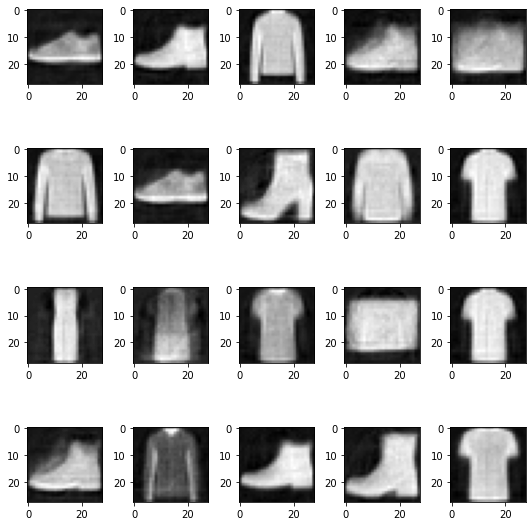

In [14]:
# make test set
test_set = torch.utils.data.TensorDataset(torch.tensor(Xtest, dtype=torch.float), torch.tensor(ytest, dtype=torch.float).reshape(-1, 1))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

n_row = 4
n_col = 5

fig, axes=plt.subplots(n_row, n_col, figsize=(1.5*n_col, 2*n_row))
for i, (images_raw, labels) in enumerate(test_loader):
    y = ae.ae(images_raw)
    images = y.detach().numpy()[0].reshape(28, 28)
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images, cmap='gray')
    if i == n_col*n_row - 1:
        break
plt.tight_layout()
plt.show()

As we can see the reconstructions look really good.

# EXTRA

We modify the autoencoder such that it has only a linear layer, this should resamble PCA

In [100]:
class Autoencoder(torch.nn.Module):
    def __init__(self,  dim):
        super().__init__()

        self.dim = dim
        self.encoder = torch.nn.Linear(in_features=28*28, out_features=self.dim, bias=False)
        self.decoder = torch.nn.Linear(in_features=self.dim, out_features=28*28, bias=False)
        self.ae = torch.nn.Sequential(self.encoder, self.decoder)
                                           
    def forward(self, x):
        return self.ae(x)


    def fit_transform(self, x, train_loader, val_loader, 
                      loss_func=torch.nn.MSELoss, optimizer=torch.optim.Adam,
                      learning_rate = 0.001,
                      num_epochs=50):

        
        model = self.ae
        optim = optimizer(model.parameters(), lr=learning_rate, weight_decay=1e-6)
        loss_func = loss_func()
        l_train =[]
        l_val = []


        for epoch in range(num_epochs+1): 
            model.train()
            loss_tr=[]

            for step, (images_raw, images_out) in enumerate(train_loader):

                optim.zero_grad()
                y = model(images_raw)
                loss = loss_func(images_out, y)
                loss_tr.append(loss.detach().item())
                loss.backward()
                optim.step()

            model.eval()
            loss_ts = []
            for step, (images_raw, images_out) in enumerate(val_loader):
                y = model(images_raw)
                loss = loss_func(images_out, y)       
                loss_ts.append(loss.detach().cpu().numpy())
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, training_loss: {np.mean(loss_tr)}, validation_loss {np.mean(loss_ts)}")

            l_train.append(np.mean(loss_tr))
            l_val.append(np.mean(loss_ts))


# build the autoencoder
ae = Autoencoder(3)
ae.fit_transform(Xtrain, train_loader, val_loader, num_epochs=200)


Epoch 0, training_loss: 0.20804383279755712, validation_loss 0.20308634638786316
Epoch 10, training_loss: 0.06945261778309941, validation_loss 0.0694822147488594
Epoch 20, training_loss: 0.061253972235135734, validation_loss 0.0623575784265995
Epoch 30, training_loss: 0.0528012573486194, validation_loss 0.05355651304125786
Epoch 40, training_loss: 0.04898089391645044, validation_loss 0.04977612569928169
Epoch 50, training_loss: 0.04734861932229251, validation_loss 0.048125363886356354
Epoch 60, training_loss: 0.04536326171364635, validation_loss 0.04596635699272156
Epoch 70, training_loss: 0.0434208728838712, validation_loss 0.043741624802351
Epoch 80, training_loss: 0.04204135329928249, validation_loss 0.04257534444332123
Epoch 90, training_loss: 0.04198514169547707, validation_loss 0.04219178482890129
Epoch 100, training_loss: 0.04175264248624444, validation_loss 0.0420842170715332
Epoch 110, training_loss: 0.041638669674284756, validation_loss 0.04207390174269676
Epoch 120, training

Let's see the latent representation

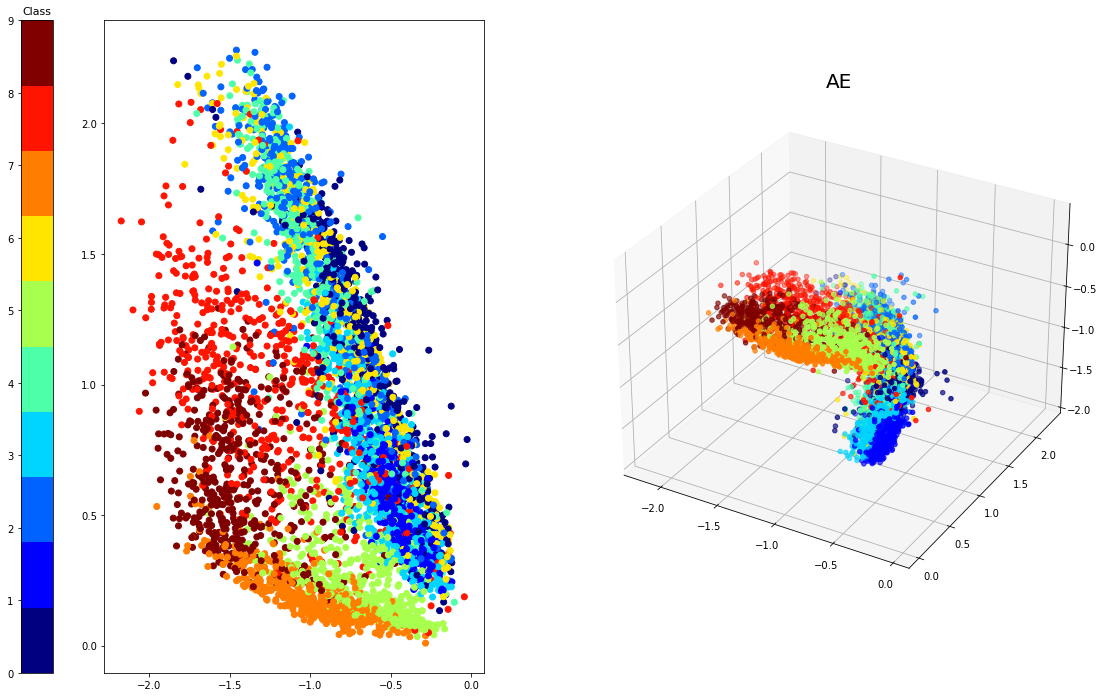

In [101]:
plot_latent(ae.encoder(train_set.dataset.tensors[0]).detach(), ytrain, 'AE')

And here the PCA:

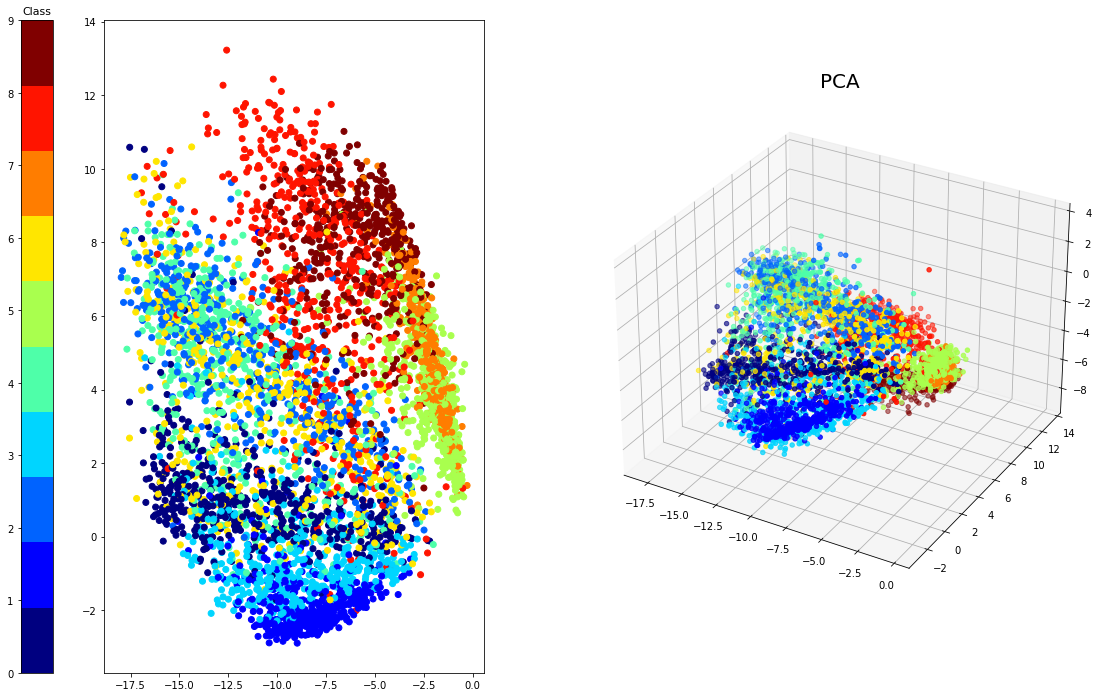

In [102]:
plot_latent(X_pca, ytrain, 'PCA')

As we can see it is a bit different than PCA. To understand why, let's examine the learnt matrices.

In [103]:
W_in = next(ae.encoder.parameters()).detach()
W_rec = next(ae.decoder.parameters()).detach()

If we multiply them we should get the identity

In [104]:
torch.matmul(W_in, W_rec)

tensor([[ 1.0017e+00, -2.3347e-03,  5.7006e-04],
        [ 2.5243e-04,  1.0001e+00, -1.0924e-03],
        [-1.6265e-03,  8.1753e-04,  9.9974e-01]])

It is clearn that the diagonal elements are very close to one, and that the not diagonal element are close to zero. However, it is not perfectly the identity, meaning that the two matrices are not perfectly orthogonal between each other.